In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.0/241.0 kB 15.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.7 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=67fb8e0a8170aeeabae51e0a2bb0265f156fb01e1f9055ff2f4c911914942303
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


In [3]:
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
import wandb

In [4]:
dataset_path = "/content/drive/MyDrive/7-7 dataset"


In [5]:
width = height = 299
img_data_generator = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    rescale=1./255 ,
    validation_split=0.1,
)
train_data= img_data_generator.flow_from_directory(
    dataset_path ,
    shuffle=True,
    subset="training",
    target_size=(width,height),
    batch_size=32
)

validation_data = img_data_generator.flow_from_directory(
    dataset_path,
    shuffle=True,
    subset="validation",
    target_size=(width,height),
    batch_size=32
)

Found 1227 images belonging to 14 classes.
Found 131 images belonging to 14 classes.


## train_data is an iterator , so :

In [6]:
next(train_data)[0].shape

(32, 299, 299, 3)

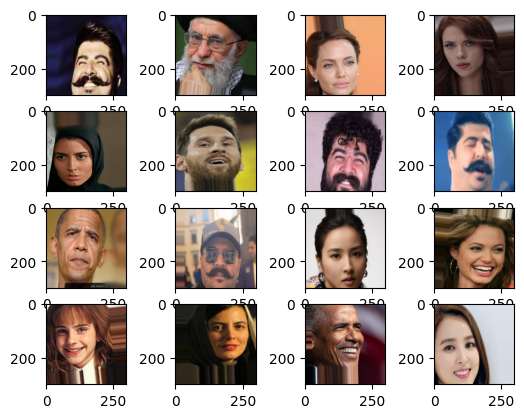

In [7]:
train_images = next(train_data)[0]
for i in range(16):
  plt.subplot(4,4,i+1)
  plt.imshow(train_images[i])

## TransferLearning : weights="imagenet"

In [8]:
initial_model = tf.keras.applications.InceptionResNetV2(weights="imagenet" , input_shape=(width,height,3))
#initial_model.summary()

225209952/225209952 [==============================] - 2s 0us/step


## include_top = False :

 ## these 2 layers have been deleted :
 ### because of include_top=False
 avg_pool (GlobalAveragePoo(None,1536))                                                           
 predictions (Dense)(None, 1000)

In [9]:
initial_model = tf.keras.applications.InceptionResNetV2(weights="imagenet" , include_top=False , input_shape=(width,height,3))
#initial_model.summary()

219055592/219055592 [==============================] - 1s 0us/step


## حالا خودمون باید اون دوتا لایه رو بسازیم ::
اما لایه پولینگ رو میتونیم اینجوری بسازیم ::
اینجوری فقط لایه دنس را حذف کردیم

In [ ]:
initial_model = tf.keras.applications.InceptionResNetV2(weights="imagenet",
                                                        include_top=False,
                                                        pooling="avg",
                                                        input_shape=(width,height,3))
#initial_model.summary()

# FREEZING SOME LAYERS :

نمیخوایم همه ی لایه ها ترین بشن

## اگر بخوایم چهار لایه آخر شبکه فریز نشوند  :
چهارتای آخر را درنظر نمیگیریم
یعنی میخوایم ۴ لایه آخر شبکه ترین بشوند ولی بقیه نه  

In [11]:
for layer in initial_model.layers[:-4]:
 layer.trainable=False

#initial_model.summary()

In [12]:
model = tf.keras.models.Sequential([
    initial_model,
    tf.keras.layers.Dropout(0.2), # 0.2 is probability that a neuron will be inactive and 80% active
    tf.keras.layers.Dense(14 , activation="softmax")
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Funct  (None, 1536)              54336736  
 ional)                                                          
                                                                 
 dropout (Dropout)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 14)                21518     
                                                                 
Total params: 54358254 (207.36 MB)
Trainable params: 3217934 (12.28 MB)
Non-trainable params: 51140320 (195.08 MB)
_________________________________________________________________


In [13]:
model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001) ,
              loss=tf.keras.losses.categorical_crossentropy ,
              metrics=["accuracy"] )

In [14]:
run = wandb.init(project="7-7-faces")

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [15]:
from wandb.sdk.wandb_run import wandb_metric
config = wandb.config
from wandb.keras import (
   WandbMetricsLogger,
   WandbModelCheckpoint,
)

wandb_callbacks = [
   WandbMetricsLogger(log_freq=5),
   WandbModelCheckpoint("models"),
]

In [16]:
history = model.fit(train_data , validation_data=validation_data , epochs=10 , callbacks=wandb_callbacks)


Epoch 1/10
39/39 [==============================] - ETA: 0s - loss: 1.1054 - accuracy: 0.6544 

wandb: Adding directory to artifact (./models)... Done. 1.0s


39/39 [==============================] - 615s 15s/step - loss: 1.1054 - accuracy: 0.6544 - val_loss: 1.1326 - val_accuracy: 0.6565
Epoch 2/10
39/39 [==============================] - ETA: 0s - loss: 0.4498 - accuracy: 0.8778

wandb: Adding directory to artifact (./models)... Done. 1.0s


39/39 [==============================] - 122s 3s/step - loss: 0.4498 - accuracy: 0.8778 - val_loss: 0.7744 - val_accuracy: 0.8015
Epoch 3/10
39/39 [==============================] - ETA: 0s - loss: 0.3193 - accuracy: 0.9209

wandb: Adding directory to artifact (./models)... Done. 1.9s


39/39 [==============================] - 116s 3s/step - loss: 0.3193 - accuracy: 0.9209 - val_loss: 0.5667 - val_accuracy: 0.8397
Epoch 4/10
39/39 [==============================] - ETA: 0s - loss: 0.2478 - accuracy: 0.9397

wandb: Adding directory to artifact (./models)... Done. 1.1s


39/39 [==============================] - 112s 3s/step - loss: 0.2478 - accuracy: 0.9397 - val_loss: 0.4978 - val_accuracy: 0.8855
Epoch 5/10
39/39 [==============================] - ETA: 0s - loss: 0.2235 - accuracy: 0.9527

wandb: Adding directory to artifact (./models)... Done. 2.2s


39/39 [==============================] - 116s 3s/step - loss: 0.2235 - accuracy: 0.9527 - val_loss: 0.5058 - val_accuracy: 0.8931
Epoch 6/10
39/39 [==============================] - ETA: 0s - loss: 0.1918 - accuracy: 0.9625

wandb: Adding directory to artifact (./models)... Done. 2.8s


39/39 [==============================] - 119s 3s/step - loss: 0.1918 - accuracy: 0.9625 - val_loss: 0.4418 - val_accuracy: 0.8855
Epoch 7/10
39/39 [==============================] - ETA: 0s - loss: 0.1478 - accuracy: 0.9731

wandb: Adding directory to artifact (./models)... Done. 1.0s


39/39 [==============================] - 117s 3s/step - loss: 0.1478 - accuracy: 0.9731 - val_loss: 0.4813 - val_accuracy: 0.8473
Epoch 8/10
39/39 [==============================] - ETA: 0s - loss: 0.1479 - accuracy: 0.9682

wandb: Adding directory to artifact (./models)... Done. 2.6s


39/39 [==============================] - 114s 3s/step - loss: 0.1479 - accuracy: 0.9682 - val_loss: 0.4088 - val_accuracy: 0.9084
Epoch 9/10
39/39 [==============================] - ETA: 0s - loss: 0.1212 - accuracy: 0.9796

wandb: Adding directory to artifact (./models)... Done. 2.8s


39/39 [==============================] - 114s 3s/step - loss: 0.1212 - accuracy: 0.9796 - val_loss: 0.4599 - val_accuracy: 0.8931
Epoch 10/10
39/39 [==============================] - ETA: 0s - loss: 0.1125 - accuracy: 0.9788

wandb: Adding directory to artifact (./models)... Done. 1.3s


39/39 [==============================] - 114s 3s/step - loss: 0.1125 - accuracy: 0.9788 - val_loss: 0.4219 - val_accuracy: 0.8779


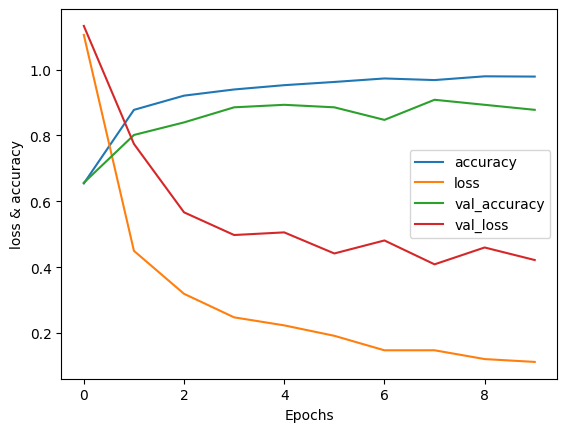

In [17]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["loss"], label='Train')
plt.plot(history.history["val_accuracy"], label='Validation')
plt.plot(history.history["val_loss"])
plt.legend(["accuracy","loss" , "val_accuracy" , "val_loss"])
plt.xlabel("Epochs")
plt.ylabel("loss & accuracy")
plt.show()

In [ ]:
images,labels = validation_data[0]
ypred_list = []
for image in images:
    image = np.expand_dims(image, axis=0)
    ypred=model.predict(image)
    ypred_list.append(np.argmax(ypred))
ytrue_list = []
for label in labels:
    ytrue_list.append(np.argmax(label))

In [31]:
np.array(ytrue_list)

array([ 3,  5,  7, 13, 13,  0, 12,  3,  7,  9,  3,  0,  9,  8,  6,  1,  8,
        5,  6, 12,  9, 10,  2,  2,  0, 11,  9,  0, 11, 13,  2,  9])

In [32]:
np.array(ypred_list)

array([ 3,  5,  7, 13, 13,  0, 12,  3,  7,  9,  3,  0,  9,  8,  6,  1,  8,
        5,  6, 12,  9,  2,  2,  2,  0, 11,  9,  0, 11, 13,  2,  9])

In [ ]:
confm = metrics.confusion_matrix(y_true= ytrue_list , y_pred= ypred_list  )
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confm , display_labels=['Ali_Khamenei', 'Angelina_Jolie', 'Barak_Obama', 'Behnam_Bani', 'Donald_Trump', 'Emma_Watson', 'Han_Hye_Jin', 'Kim_Jong_Un', 'Leyla_Hatami', 'Lionel_Messi', 'Michelle_Obama', 'Morgan_Freeman', 'Queen_Elizabeth', 'Scarlett_Johansson' ])
cm_display.plot(cmap=plt.cm.Oranges , xticks_rotation="vertical")
plt.show()

# Inference

شبکه همیشه تصاویر را به صورت بچ میخواد از ما . یعنی ورودی شبکه همیشه ۴ بعدی است .
یکی از این ۴ تا بعد بچ سایز است
اما حالا که فقط میخوایم یک تصویر بدیم بازم باید تصویر رو ۴ بعدی بکنیم


1/1 [==============================] - 0s 43ms/step
1
{'Ali_Khamenei': 0, 'Angelina_Jolie': 1, 'Barak_Obama': 2, 'Behnam_Bani': 3, 'Donald_Trump': 4, 'Emma_Watson': 5, 'Han_Hye_Jin': 6, 'Kim_Jong_Un': 7, 'Leyla_Hatami': 8, 'Lionel_Messi': 9, 'Michelle_Obama': 10, 'Morgan_Freeman': 11, 'Queen_Elizabeth': 12, 'Scarlett_Johansson': 13}
predicted label :  Angelina_Jolie


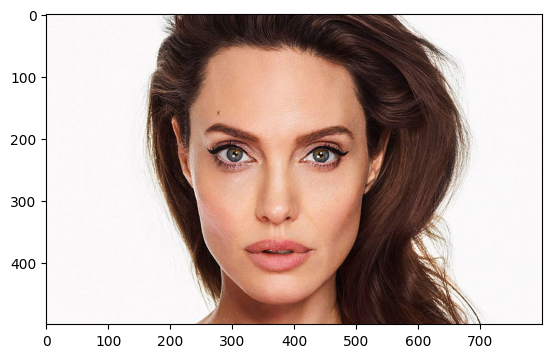

1/1 [==============================] - 0s 41ms/step
1
{'Ali_Khamenei': 0, 'Angelina_Jolie': 1, 'Barak_Obama': 2, 'Behnam_Bani': 3, 'Donald_Trump': 4, 'Emma_Watson': 5, 'Han_Hye_Jin': 6, 'Kim_Jong_Un': 7, 'Leyla_Hatami': 8, 'Lionel_Messi': 9, 'Michelle_Obama': 10, 'Morgan_Freeman': 11, 'Queen_Elizabeth': 12, 'Scarlett_Johansson': 13}
predicted label :  Angelina_Jolie


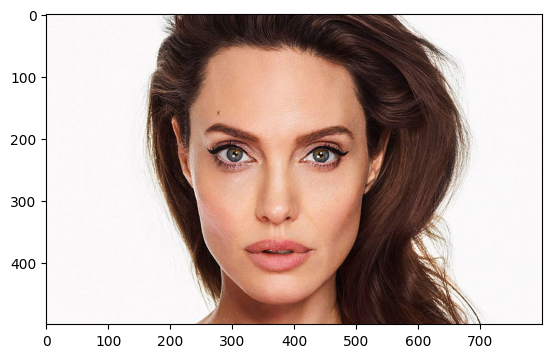

In [26]:
import cv2

new_image = cv2.imread("/content/angelina1.jpg")
new_image = cv2.cvtColor(new_image , cv2.COLOR_BGR2RGB)
plt.imshow(new_image)
new_image = cv2.resize(new_image , (299,299))
new_image = new_image / 255.0
new_image = np.reshape(new_image, [1, 299, 299, 3]) # new_iamge.reshape(1,299,299,3)

output = model.predict(new_image)

predicted_class = np.argmax(output)
print(predicted_class)
print(train_data.class_indices)
mylist = list(train_data.class_indices)
print("predicted label : " , mylist[np.argmax(output)])

1/1 [==============================] - 0s 42ms/step
2
{'Ali_Khamenei': 0, 'Angelina_Jolie': 1, 'Barak_Obama': 2, 'Behnam_Bani': 3, 'Donald_Trump': 4, 'Emma_Watson': 5, 'Han_Hye_Jin': 6, 'Kim_Jong_Un': 7, 'Leyla_Hatami': 8, 'Lionel_Messi': 9, 'Michelle_Obama': 10, 'Morgan_Freeman': 11, 'Queen_Elizabeth': 12, 'Scarlett_Johansson': 13}
predicted label :  Barak_Obama


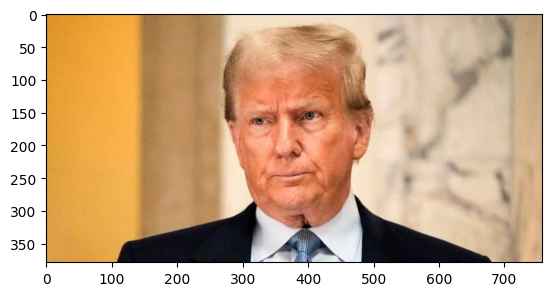

1/1 [==============================] - 0s 46ms/step
2
{'Ali_Khamenei': 0, 'Angelina_Jolie': 1, 'Barak_Obama': 2, 'Behnam_Bani': 3, 'Donald_Trump': 4, 'Emma_Watson': 5, 'Han_Hye_Jin': 6, 'Kim_Jong_Un': 7, 'Leyla_Hatami': 8, 'Lionel_Messi': 9, 'Michelle_Obama': 10, 'Morgan_Freeman': 11, 'Queen_Elizabeth': 12, 'Scarlett_Johansson': 13}
predicted label :  Barak_Obama


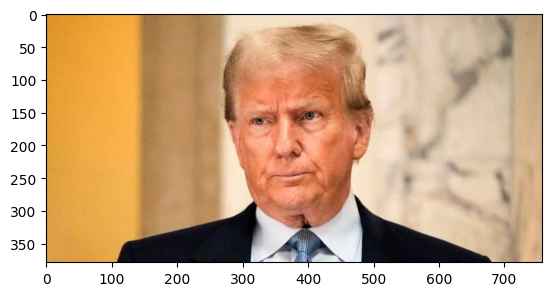

In [27]:
new_image = cv2.imread("/content/trump.jpg")
new_image = cv2.cvtColor(new_image , cv2.COLOR_BGR2RGB)
plt.imshow(new_image)
new_image = cv2.resize(new_image , (299,299))
new_image = new_image / 255.0
new_image = np.reshape(new_image, [1, 299, 299, 3]) # new_iamge.reshape(1,299,299,3)

output = model.predict(new_image)

predicted_class = np.argmax(output)
print(predicted_class)
print(train_data.class_indices)
mylist = list(train_data.class_indices)
print("predicted label : " , mylist[np.argmax(output)])

1/1 [==============================] - 0s 41ms/step
2
{'Ali_Khamenei': 0, 'Angelina_Jolie': 1, 'Barak_Obama': 2, 'Behnam_Bani': 3, 'Donald_Trump': 4, 'Emma_Watson': 5, 'Han_Hye_Jin': 6, 'Kim_Jong_Un': 7, 'Leyla_Hatami': 8, 'Lionel_Messi': 9, 'Michelle_Obama': 10, 'Morgan_Freeman': 11, 'Queen_Elizabeth': 12, 'Scarlett_Johansson': 13}
predicted label :  Barak_Obama


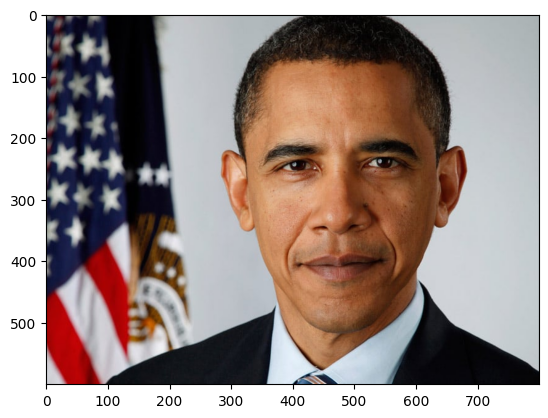

1/1 [==============================] - 0s 40ms/step
2
{'Ali_Khamenei': 0, 'Angelina_Jolie': 1, 'Barak_Obama': 2, 'Behnam_Bani': 3, 'Donald_Trump': 4, 'Emma_Watson': 5, 'Han_Hye_Jin': 6, 'Kim_Jong_Un': 7, 'Leyla_Hatami': 8, 'Lionel_Messi': 9, 'Michelle_Obama': 10, 'Morgan_Freeman': 11, 'Queen_Elizabeth': 12, 'Scarlett_Johansson': 13}
predicted label :  Barak_Obama


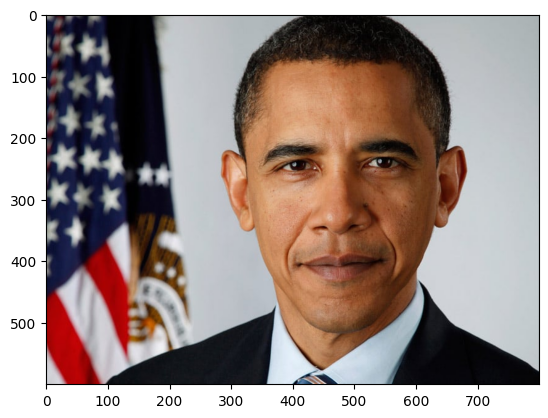

In [28]:
new_image = cv2.imread("/content/Obama.jpg")
new_image = cv2.cvtColor(new_image , cv2.COLOR_BGR2RGB)
plt.imshow(new_image)
new_image = cv2.resize(new_image , (299,299))
new_image = new_image / 255.0
new_image = np.reshape(new_image, [1, 299, 299, 3]) # new_iamge.reshape(1,299,299,3)

output = model.predict(new_image)

predicted_class = np.argmax(output)
print(predicted_class)
print(train_data.class_indices)
mylist = list(train_data.class_indices)
print("predicted label : " , mylist[np.argmax(output)])

1/1 [==============================] - 0s 40ms/step
12
{'Ali_Khamenei': 0, 'Angelina_Jolie': 1, 'Barak_Obama': 2, 'Behnam_Bani': 3, 'Donald_Trump': 4, 'Emma_Watson': 5, 'Han_Hye_Jin': 6, 'Kim_Jong_Un': 7, 'Leyla_Hatami': 8, 'Lionel_Messi': 9, 'Michelle_Obama': 10, 'Morgan_Freeman': 11, 'Queen_Elizabeth': 12, 'Scarlett_Johansson': 13}
predicted label :  Queen_Elizabeth


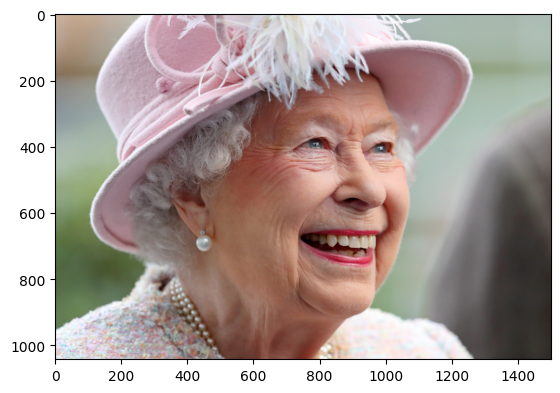

1/1 [==============================] - 0s 65ms/step
12
{'Ali_Khamenei': 0, 'Angelina_Jolie': 1, 'Barak_Obama': 2, 'Behnam_Bani': 3, 'Donald_Trump': 4, 'Emma_Watson': 5, 'Han_Hye_Jin': 6, 'Kim_Jong_Un': 7, 'Leyla_Hatami': 8, 'Lionel_Messi': 9, 'Michelle_Obama': 10, 'Morgan_Freeman': 11, 'Queen_Elizabeth': 12, 'Scarlett_Johansson': 13}
predicted label :  Queen_Elizabeth


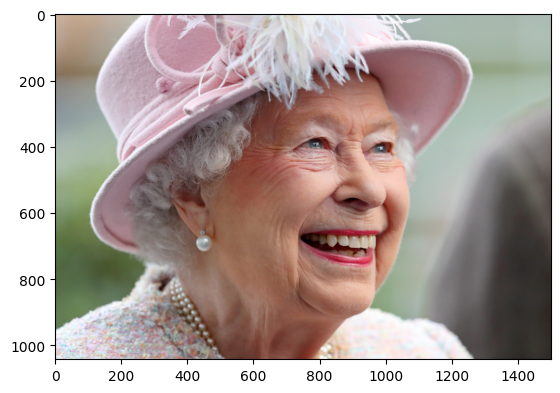

In [29]:
new_image = cv2.imread("/content/queen.jpg")
new_image = cv2.cvtColor(new_image , cv2.COLOR_BGR2RGB)
plt.imshow(new_image)
new_image = cv2.resize(new_image , (299,299))
new_image = new_image / 255.0
new_image = np.reshape(new_image, [1, 299, 299, 3]) # new_iamge.reshape(1,299,299,3)

output = model.predict(new_image)

predicted_class = np.argmax(output)
print(predicted_class)
print(train_data.class_indices)
mylist = list(train_data.class_indices)
print("predicted label : " , mylist[np.argmax(output)])